<a href="https://colab.research.google.com/github/aviavice/image_segmentation_task/blob/main/image_segmentation_1st_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Segmentation task**
**Author**: Aismantė Vaivadaitė \
**LSP**: 2315994 \
\
For this deep learning task, the objective was to build a model which classifies each pixel into one of three or more object classes. My selected classes were *Car*, *Person*, and *Cat*, based on available number in the class of segmentation masks in the *OpenImages* dataset.\
I initially tried to perform the task locally on my machine, using Python 3.13 but due difficulties of library handling and GPU support switched to *Google Colab*.
* I used *FiftyOne* to download segmented data from *OpenImages v7*.
* Created a custom *PyTorch* *SegmentationDataset* class to process instance masks into unified semantic mask.
* Built a custom segmentation model *CustomSegNet*, based on *DeepLabV3+*.
* Trained the model for 10 epochs, saved it to *Google Drive* for reuse.
* Evaluated it using following metrics - *Accuracy*, *Precision*, *Recall*, *F1 Score* - from *sklearn.metrics* on 100 unseen test images.
* Visualised results.

The additional task: Benchmark comparison with existing pre-trainedimage segmentation models like Segment Anything was not performed.

In [2]:
!pip install fiftyone --quiet
!pip install opencv-python-headless --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 68.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.9/110.9 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 943.0/943.0 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.6/139.6 kB 9.3 MB/s eta 0:00:0

In [3]:
# set up Google Drive integration and create output directory for saving the trained model
from google.colab import drive
import os

drive.mount('/content/drive')

base_path = '/content/drive/MyDrive/image_segmentation_project'
output_path = os.path.join(base_path, 'outputs')
os.makedirs(output_path, exist_ok=True)

print("Google Drive mounted. Output directory is ready.")

Mounted at /content/drive
Google Drive mounted. Output directory is ready.


In [4]:
# --- Core Python ---
import os
import time

# --- Math / Array / Image ---
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

# --- PyTorch ---
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# --- Evaluation ---
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# --- Dataset: FiftyOne ---
import fiftyone as fo
import fiftyone.zoo as foz
import fiftyone.utils.openimages as foui

In [ ]:
'''
segmentation_classes = foui.get_segmentation_classes()
print(segmentation_classes)
'''

# lists all segmentation classes available in OpenImages. ran to see classes for choosing
# selected classes: car, person, cat

INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv' to '/tmp/tmpbel9vvlk/metadata/classes.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/classes-segmentation.txt' to '/tmp/tmpbel9vvlk/metadata/segmentation_classes.csv'


['Adhesive tape', 'Aircraft', 'Airplane', 'Alarm clock', 'Alpaca', 'Ambulance', 'Apple', 'Armadillo', 'Artichoke', 'Axe', 'Backpack', 'Bagel', 'Balance beam', 'Ball', 'Balloon', 'Banana', 'Band-aid', 'Barge', 'Barrel', 'Baseball bat', 'Baseball glove', 'Bat (Animal)', 'Beaker', 'Bear', 'Beer', 'Bell pepper', 'Belt', 'Bicycle wheel', 'Billiard table', 'Binoculars', 'Bird', 'Blue jay', 'Bomb', 'Book', 'Boot', 'Bottle', 'Bottle opener', 'Bowl', 'Box', 'Boy', 'Bread', 'Briefcase', 'Broccoli', 'Bronze sculpture', 'Brown bear', 'Bull', 'Burrito', 'Bus', 'Bust', 'Cabbage', 'Cake', 'Calculator', 'Camel', 'Camera', 'Canary', 'Candle', 'Canoe', 'Cantaloupe', 'Car', 'Carnivore', 'Carrot', 'Cat', 'Cattle', 'Cello', 'Cheese', 'Cheetah', 'Chest of drawers', 'Chicken', 'Chisel', 'Chopsticks', 'Christmas tree', 'Clock', 'Clothing', 'Cocktail', 'Cocktail shaker', 'Coffee', 'Coffee cup', 'Coin', 'Common fig', 'Common sunflower', 'Computer keyboard', 'Computer mouse', 'Cookie', 'Cooking spray', 'Corded p

# Load OpenImages Segmentation Datasets

Downloads the train, validation, and test datasets from *OpenImages v7* using *FiftyOne* of following classes: *Car*, *Person*, and *Cat*.\
Only images that contain at least one of the selected classes are included.

In [5]:
selected_classes = ["Car", "Person", "Cat"]

# training data
train_dataset = foz.load_zoo_dataset(
  "open-images-v7",
  split = "train",
  label_types = "segmentations",
  max_samples = 1000,  # number of samples can be changed here
  classes = selected_classes,
  only_matching = True,
  dataset_name = "train_set"
)

# validation data
val_dataset = foz.load_zoo_dataset(
  "open-images-v7",
  split = "validation",
  label_types = "segmentations",
  max_samples = 150, # number of samples can be changed here
  classes = selected_classes,
  only_matching = True,
  dataset_name = "val_set"
)

# test data
test_dataset = foz.load_zoo_dataset(
  "open-images-v7",
  split = "test",
  label_types = "segmentations",
  max_samples = 100, # number of samples can be changed here
  classes = selected_classes,
  only_matching = True,
  dataset_name = "test_set"
)

print("Datasets downloaded and loaded into memory.")

INFO:fiftyone.zoo.datasets:Downloading split 'train' to '/root/fiftyone/open-images-v7/train' if necessary


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/2018_04/train/train-images-boxable-with-rotation.csv' to '/root/fiftyone/open-images-v7/train/metadata/image_ids.csv'


 100% |██████|    4.8Gb/4.8Gb [9.2s elapsed, 0s remaining, 961.4Mb/s]       


INFO:eta.core.utils: 100% |██████|    4.8Gb/4.8Gb [9.2s elapsed, 0s remaining, 961.4Mb/s]       


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv' to '/root/fiftyone/open-images-v7/train/metadata/classes.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/classes-segmentation.txt' to '/root/fiftyone/open-images-v7/train/metadata/segmentation_classes.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/2018_04/bbox_labels_600_hierarchy.json' to '/tmp/tmpw3980g_s/metadata/hierarchy.json'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/train-annotations-object-segmentation.csv' to '/root/fiftyone/open-images-v7/train/labels/segmentations.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/train-masks/train-masks-0.zip' to '/root/fiftyone/open-images-v7/train/labels/masks/0.zip'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/train-masks/train-masks-4.zip' to '/root/fiftyone/open-images-v7/train/labels/masks/4.zip'


INFO:fiftyone.utils.openimages:Downloading 1000 images


 100% |█████████████████| 1000/1000 [2.0m elapsed, 0s remaining, 7.1 files/s]       


INFO:eta.core.utils: 100% |█████████████████| 1000/1000 [2.0m elapsed, 0s remaining, 7.1 files/s]       


Dataset info written to '/root/fiftyone/open-images-v7/info.json'


INFO:fiftyone.zoo.datasets:Dataset info written to '/root/fiftyone/open-images-v7/info.json'


Loading 'open-images-v7' split 'train'


INFO:fiftyone.zoo.datasets:Loading 'open-images-v7' split 'train'


 100% |███████████████| 1000/1000 [1.2m elapsed, 0s remaining, 20.1 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 1000/1000 [1.2m elapsed, 0s remaining, 20.1 samples/s]      


Dataset 'train_set' created


INFO:fiftyone.zoo.datasets:Dataset 'train_set' created


INFO:fiftyone.zoo.datasets:Downloading split 'validation' to '/root/fiftyone/open-images-v7/validation' if necessary


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/2018_04/validation/validation-images-with-rotation.csv' to '/root/fiftyone/open-images-v7/validation/metadata/image_ids.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv' to '/root/fiftyone/open-images-v7/validation/metadata/classes.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/classes-segmentation.txt' to '/root/fiftyone/open-images-v7/validation/metadata/segmentation_classes.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/2018_04/bbox_labels_600_hierarchy.json' to '/tmp/tmpuowoc6xj/metadata/hierarchy.json'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/validation-annotations-object-segmentation.csv' to '/root/fiftyone/open-images-v7/validation/labels/segmentations.csv'


INFO:fiftyone.utils.openimages:Downloading 150 images


 100% |███████████████████| 150/150 [18.8s elapsed, 0s remaining, 8.8 files/s]      


INFO:eta.core.utils: 100% |███████████████████| 150/150 [18.8s elapsed, 0s remaining, 8.8 files/s]      


Dataset info written to '/root/fiftyone/open-images-v7/info.json'


INFO:fiftyone.zoo.datasets:Dataset info written to '/root/fiftyone/open-images-v7/info.json'


Loading 'open-images-v7' split 'validation'


INFO:fiftyone.zoo.datasets:Loading 'open-images-v7' split 'validation'


 100% |█████████████████| 150/150 [5.4s elapsed, 0s remaining, 28.2 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 150/150 [5.4s elapsed, 0s remaining, 28.2 samples/s]      


Dataset 'val_set' created


INFO:fiftyone.zoo.datasets:Dataset 'val_set' created


INFO:fiftyone.zoo.datasets:Downloading split 'test' to '/root/fiftyone/open-images-v7/test' if necessary


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/2018_04/test/test-images-with-rotation.csv' to '/root/fiftyone/open-images-v7/test/metadata/image_ids.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv' to '/root/fiftyone/open-images-v7/test/metadata/classes.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/classes-segmentation.txt' to '/root/fiftyone/open-images-v7/test/metadata/segmentation_classes.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/2018_04/bbox_labels_600_hierarchy.json' to '/tmp/tmpzri40qh_/metadata/hierarchy.json'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/test-annotations-object-segmentation.csv' to '/root/fiftyone/open-images-v7/test/labels/segmentations.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/test-masks/test-masks-0.zip' to '/root/fiftyone/open-images-v7/test/labels/masks/0.zip'


INFO:fiftyone.utils.openimages:Downloading 100 images


 100% |███████████████████| 100/100 [12.6s elapsed, 0s remaining, 7.0 files/s]      


INFO:eta.core.utils: 100% |███████████████████| 100/100 [12.6s elapsed, 0s remaining, 7.0 files/s]      


Dataset info written to '/root/fiftyone/open-images-v7/info.json'


INFO:fiftyone.zoo.datasets:Dataset info written to '/root/fiftyone/open-images-v7/info.json'


Loading 'open-images-v7' split 'test'


INFO:fiftyone.zoo.datasets:Loading 'open-images-v7' split 'test'


 100% |█████████████████| 100/100 [4.4s elapsed, 0s remaining, 27.5 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 100/100 [4.4s elapsed, 0s remaining, 27.5 samples/s]      


Dataset 'test_set' created


INFO:fiftyone.zoo.datasets:Dataset 'test_set' created


Datasets downloaded and loaded into memory.


In [20]:
# Used for deleting existing FiftyOne datasets from memory (was used when changing and looking for most suitable classes)
'''
fo.delete_dataset("train_set")
fo.delete_dataset("val_set")
fo.delete_dataset("test_set")
'''

In [5]:
# To check number of object instances per class in each dataset split
print("Train class counts:\n", train_dataset.count_values("ground_truth.detections.label"))
print("Validation class counts:\n", val_dataset.count_values("ground_truth.detections.label"))
print("Test class counts:\n", test_dataset.count_values("ground_truth.detections.label"))

{'Person': 691, 'Car': 1136, 'Cat': 103}
{'Cat': 51, 'Car': 55, 'Person': 47}
{'Person': 48, 'Cat': 5, 'Car': 52}


# Segmentation class
Custom dataset class to convert *FiftyOne* segmentation samples into image + semantic mask pairs for training.

In [6]:
# mapping and colours used for visualisation
LABEL_MAPPING = {"Car": 1, "Person": 2, "Cat": 3}
LABEL_COLORS = {
    0: (0, 0, 0),   # background - black
    1: (255, 0, 0), # car - red
    2: (0, 255, 0), # person - green
    3: (0, 0, 255)  # cat - green
}

In [7]:
class SegmentationDataset(Dataset):
  def __init__(self, fiftyone_dataset, transform=None, target_size=(256, 256)):
    # storing the dataset, transformation function, and size (256, 256)
    self.samples = fiftyone_dataset
    self.target_size = target_size
    self.transform = transform

    # mapping of labels to indexes
    self.mapping = LABEL_MAPPING

  def __len__(self):
    # total number of samples in dataset
    return len(self.samples)

  def __getitem__(self, idx):
    # sample at specified index converted to RGB, resized to specified size
    sample = self.samples[idx]

    image_pil = Image.open(sample.filepath).convert("RGB")
    image_np = np.array(image_pil)
    original_height, original_width = image_np.shape[:2]
    image_resized = image_pil.resize(self.target_size)
    # blank mask
    mask = np.zeros(self.target_size[::-1], dtype=np.uint8)  # (height, width)

    # iterate over all objects in image
    for det in sample.ground_truth.detections:
      label = det.label
      if det.mask is not None and label in self.mapping:
        bbox = det.bounding_box
        mask_array = det.mask.astype(np.uint8)

        # coordinates from relative to absolute
        x_min = max(int(bbox[0] * original_width), 0)
        y_min = max(int(bbox[1] * original_height), 0)
        x_max = min(int((bbox[0] + bbox[2]) * original_width), original_width)
        y_max = min(int((bbox[1] + bbox[3]) * original_height), original_height)


        # mask resized to fit bbox
        resized_mask = cv2.resize(mask_array, (x_max - x_min, y_max - y_min), interpolation=cv2.INTER_NEAREST)

        # mask size back to original image size
        object_mask = np.zeros((original_height, original_width), dtype=np.uint8)
        object_mask[y_min:y_max, x_min:x_max] = resized_mask * self.mapping[label]
        object_mask_resized = cv2.resize(object_mask, self.target_size[::-1], interpolation=cv2.INTER_NEAREST)

        mask = np.maximum(mask, object_mask_resized)

    # image transformation
    if self.transform:
      image = self.transform(image)

    # lastly return the processed image and its mask as a tensor
    return image, torch.tensor(mask, dtype=torch.long)

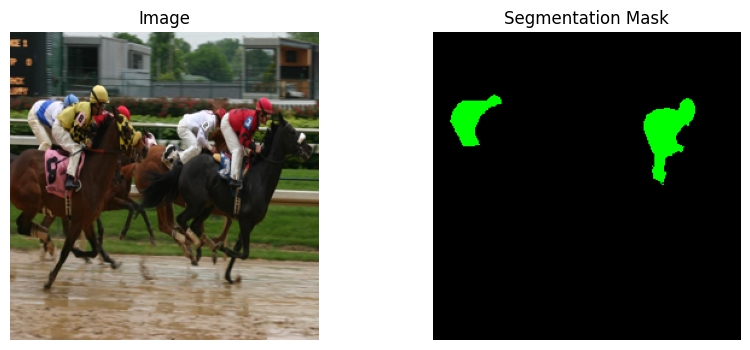

In [8]:
# displays one sample from the training dataset to verify that the segmentation mask aligns correctly with the image.
train_samples = list(train_dataset)
train_data = SegmentationDataset(train_samples, transform=transforms.ToTensor())

image, mask = train_data[80] # change the numebr of the image in the training set
image_np = image.permute(1, 2, 0).numpy()
mask_np = mask.numpy()

mask_rgb = np.zeros((*mask_np.shape, 3), dtype=np.uint8)
for class_idx, color in LABEL_COLORS.items():
  mask_rgb[mask_np == class_idx] = color

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(image_np)
plt.title("Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask_rgb)
plt.title("Segmentation Mask")
plt.axis("off")

plt.show()

# Model
**CustomSegNet Model**\
This is a custom semantic segmentation model resembling *DeepLabV3+*. It follows an **encoder–bottleneck–decoder** architecture:
* **Encoder:** Downsamples the input image using convolutional blocks and max pooling. This helps extract deeper features at lower resolutions.
* **Bottleneck:** Applies two **dilated convolutions** to increase the receptive field without further reducing resolution.
* **Decoder:** Upsamples the feature maps back to the original image size using bilinear upsampling followed by convolution. This reconstructs spatial details.
* **Final Layer:** A 1×1 convolution maps the upsampled features to pixel-wise class predictions.

The model outputs a tensor of shape `[B, num_classes, H, W]`,  
where each pixel has a predicted class score.


In [9]:
class CustomSegNet(nn.Module):
  def __init__(self, num_classes=4):  # 3 classes + background
    super(CustomSegNet, self).__init__()

    # ----------- Encoder -----------
    self.enc1 = self.conv_block(3, 64)
    self.enc2 = self.conv_block(64, 128)
    self.enc3 = self.conv_block(128, 256)

    self.pool = nn.MaxPool2d(2, 2)

    # ----------- Bottleneck -----------
    self.bottleneck = nn.Sequential(
      nn.Conv2d(256, 256, kernel_size=3, padding=2, dilation=2),
      nn.ReLU(inplace=True),
      nn.Conv2d(256, 256, kernel_size=3, padding=4, dilation=4),
      nn.ReLU(inplace=True)
    )

    # ----------- Decoder -----------
    self.up3 = self.upsample_block(256, 128)
    self.up2 = self.upsample_block(128, 64)
    self.up1 = self.upsample_block(64, 32)

    # ----------- Final classifierr -----------
    self.final_conv = nn.Conv2d(32, num_classes, kernel_size=1)

  def conv_block(self, in_channels, out_channels):
    '''Convolutional block: 2 conv layers with ReLU'''
    return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
      nn.ReLU(inplace=True)
    )

  def upsample_block(self, in_channels, out_channels):
    '''Upsample by 2x and apply 1 conv + ReLU'''
    return nn.Sequential(
      nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
      nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
      nn.ReLU(inplace=True)
    )

  def forward(self, x):
    # --- Encoder ---
    x1 = self.enc1(x)
    x2 = self.enc2(self.pool(x1))
    x3 = self.enc3(self.pool(x2))

    # --- Bottleneck ---
    x = self.bottleneck(self.pool(x3))

    # --- Decoder ---
    x = self.up3(x)
    x = self.up2(x)
    x = self.up1(x)

    # --- Final Classifier ---
    out = self.final_conv(x)
    return out

In [15]:
# test for verifying model output shape
'''
Performs a forward pass with a random input image to verify that the model produces output with the correct shape:
[batch_size, num_classes, height, width]
'''

model = CustomSegNet(num_classes=4)  # background + 3 classes
dummy_input = torch.randn(1, 3, 256, 256)

output = model(dummy_input)

print("Input shape:", dummy_input.shape) # Expected: [1, 3, 256, 256]
print("Output shape:", output.shape)     # Expected: [1, 4, 256, 256]

Input shape: torch.Size([1, 3, 256, 256])
Output shape: torch.Size([1, 4, 256, 256])


In [16]:
# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# image transformation to tensor
transform = transforms.ToTensor()

# datasets for train and val
train_data = SegmentationDataset(list(train_dataset), transform=transform)
val_data = SegmentationDataset(list(val_dataset), transform=transform)

# DataLoader with param 4 (batch_size)
train_loader = DataLoader(train_data, batch_size=4, shuffle=True, num_workers=0)
val_loader = DataLoader(val_data, batch_size=4, shuffle=False, num_workers=0)

# model, loss, optimizer
model = CustomSegNet(num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Using device: cpu


In [17]:
# verify that a full batch of training data moves through the model without error, and dimensions align.
sample_images, sample_masks = next(iter(train_loader))

sample_images = sample_images.to(device)
sample_masks = sample_masks.to(device)

with torch.no_grad():
  outputs = model(sample_images)

print("Forward pass was successful.")
print("Input shape:", sample_images.shape)
print("Output shape:", outputs.shape)
print("Mask shape:", sample_masks.shape)

Forward pass was successful.
Input shape: torch.Size([4, 3, 256, 256])
Output shape: torch.Size([4, 4, 256, 256])
Mask shape: torch.Size([4, 256, 256])


# Training
Trains the *CustomSegNet* model for a fixed number of epochs. In my case - 10.\
Logs the training and validation loss at each epoch and prints total time per epoch.Tracks training and validation loss, and saves the final model.

In [13]:
num_epochs = 10
best_val_loss = float("inf")

# store training/validation losses
train_losses = []
val_losses = []

for epoch in range(num_epochs):
  print(f"Epoch {epoch+1}/{num_epochs}")
  model.train()
  running_loss = 0.0
  start_time = time.time()

  # --- Training  ---
  for images, masks in train_loader:
    images, masks = images.to(device), masks.to(device)

    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, masks)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  avg_train_loss = running_loss / len(train_loader)
  train_losses.append(avg_train_loss)

  # --- Validation ---
  model.eval()
  val_loss = 0.0
  with torch.no_grad():
    for images, masks in val_loader:
      images, masks = images.to(device), masks.to(device)
      outputs = model(images)
      loss = criterion(outputs, masks)
      val_loss += loss.item()

  avg_val_loss = val_loss / len(val_loader)
  val_losses.append(avg_val_loss)

  epoch_time = time.time() - start_time
  print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Time: {epoch_time:.2f}s")

print("Training completed.")

final_model_path = os.path.join(output_path, "final_segmentation_model.pth")
torch.save(model.state_dict(), final_model_path)
print(f"Final model saved to: {final_model_path}")

Epoch 1/10
Train Loss: 0.7243 | Val Loss: 0.8496 | Time: 2342.25s
Epoch 2/10
Train Loss: 0.6603 | Val Loss: 0.9160 | Time: 2285.75s
Epoch 3/10
Train Loss: 0.6663 | Val Loss: 0.9320 | Time: 2280.37s
Epoch 4/10
Train Loss: 0.6514 | Val Loss: 0.8651 | Time: 2286.30s
Epoch 5/10
Train Loss: 0.6393 | Val Loss: 0.8416 | Time: 2286.72s
Epoch 6/10
Train Loss: 0.6348 | Val Loss: 0.8314 | Time: 2271.00s
Epoch 7/10
Train Loss: 0.6203 | Val Loss: 0.9154 | Time: 2285.36s
Epoch 8/10
Train Loss: 0.6130 | Val Loss: 0.8880 | Time: 2305.77s
Epoch 9/10
Train Loss: 0.5891 | Val Loss: 0.7975 | Time: 2300.40s
Epoch 10/10
Train Loss: 0.5819 | Val Loss: 0.7596 | Time: 2301.70s
Training completed.
Final model saved to: /content/drive/MyDrive/image_segmentation_project/outputs/final_segmentation_model.pth


## Results of Training
The training loss consistently decreases over the 10 epochs, indicating that the model is learning from the data.\
However, validation loss fluctuates more but shows an overall downward trend by the end, suggesting some improvement.\
Training took approximately **38 minutes per epoch**, totaling around **6.3 hours** for the full training process on Colab.\
**Further improvements to consider:**
* Making sure to work on GPU;
* Further improvements on the model, or sample size reduction might've increased the speed.

In [12]:
# training statistics
num_epochs = 10
train_losses = [0.7243, 0.6603, 0.6663, 0.6514, 0.6393, 0.6348, 0.6203, 0.6130, 0.5891, 0.5819]
val_losses = [0.8496, 0.9160, 0.9320, 0.8651, 0.8416, 0.8314, 0.9154, 0.8880, 0.7975, 0.7596]
epoch_times = [2342.25, 2285.75, 2280.37, 2286.30, 2286.72, 2271.00, 2285.36, 2305.77, 2300.40, 2301.70]

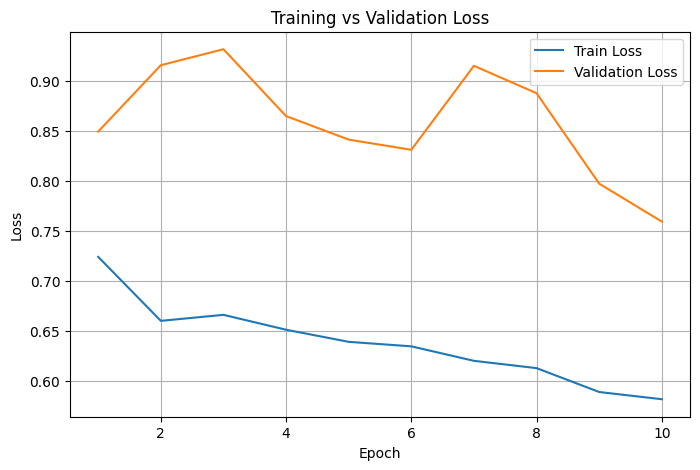

In [13]:
# plotting training stats
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
* Load trained saved model from drive
* Prepare test data for model evaluation
* Perform the evaluation using metrics: Accuracy, Precision, Recall, F1 Score.

In [18]:
final_model_path = '/content/drive/MyDrive/image_segmentation_project/outputs/final_segmentation_model.pth'
model.load_state_dict(torch.load(final_model_path))
model.eval()

CustomSegNet(
  (enc1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bottleneck): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), str

In [19]:
test_samples = list(test_dataset)
test_data = SegmentationDataset(test_samples, transform=transform)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

# computting pixel-wise classification metrics
def evaluate_model(model, dataloader, device):
  model.eval()
  y_true = []
  y_pred = []

  with torch.no_grad():
    for images, masks in dataloader:
      images = images.to(device)
      masks = masks.to(device)

      outputs = model(images)
      preds = torch.argmax(outputs, dim=1)

      y_true.extend(masks.cpu().numpy().flatten())
      y_pred.extend(preds.cpu().numpy().flatten())

  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred, average="weighted", zero_division=0)
  recall = recall_score(y_true, y_pred, average="weighted", zero_division=0)
  f1 = f1_score(y_true, y_pred, average="weighted", zero_division=0)

  print(f"Test Accuracy:  {accuracy:.4f}")
  print(f"Test Precision: {precision:.4f}")
  print(f"Test Recall:    {recall:.4f}")
  print(f"Test F1 Score:  {f1:.4f}")

evaluate_model(model, test_loader, device)

Test Accuracy:  0.7556
Test Precision: 0.6165
Test Recall:    0.7556
Test F1 Score:  0.6592


## Evaluation results

The model achieved **accuracy of 75.56%** on the unseen test set, indicating quite good overall results.
* **Precision (61.65%)** shows that when the model predicted a class, it was correct ~62% of the time.
* **Recall (75.56%)** matches the accuracy, meaning the model successfully detected most of the true object pixels.
* **F1 Score (65.92%)** reflects a balance between precision and recall, indicating moderate results.

Overall, the model shows good segmentation results on the selected classes: *Car*, *Person*, and *Cat*.

## Visualisation of results
Shows side-by-side comparison of the input image, ground truth mask, and predicted segmentation mask for a few test samples.\
Each class is shown in a unique RGB color for easier interpretation.\
Predited mask did not always display results meaning, the model was not perfect and could benefit from more training.

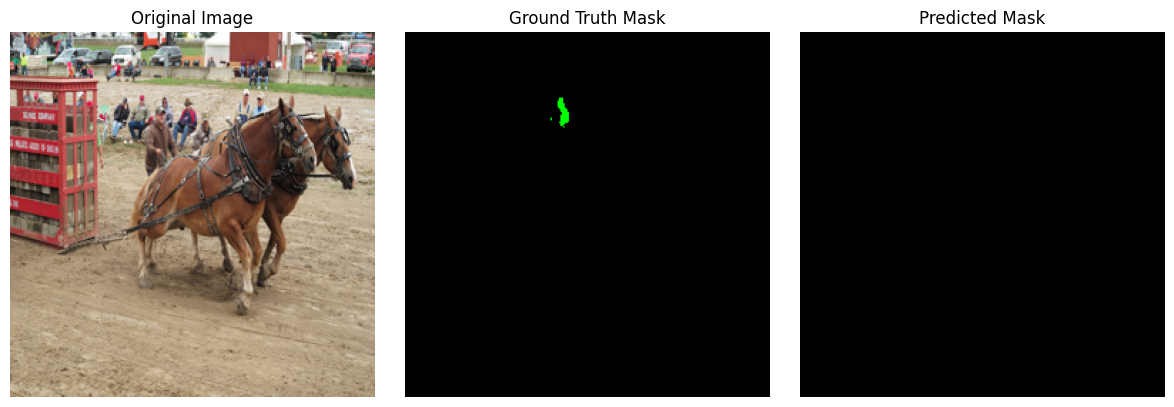

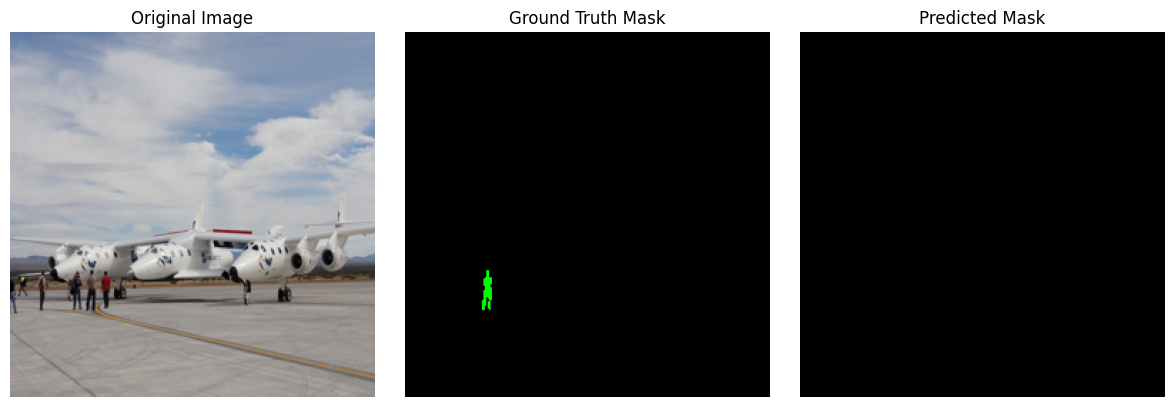

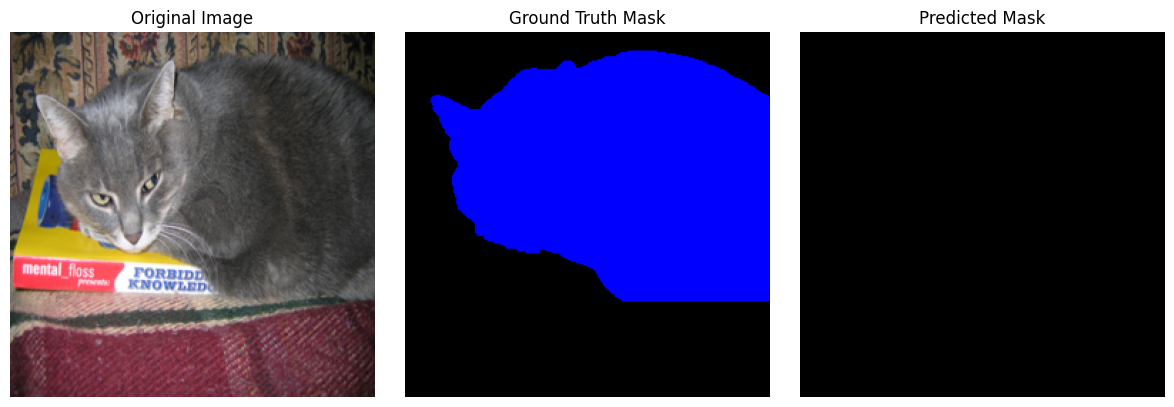

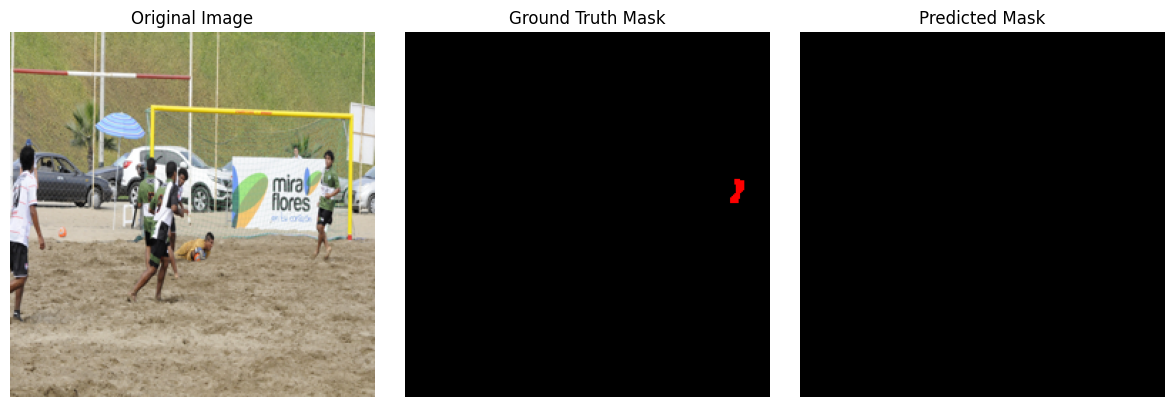

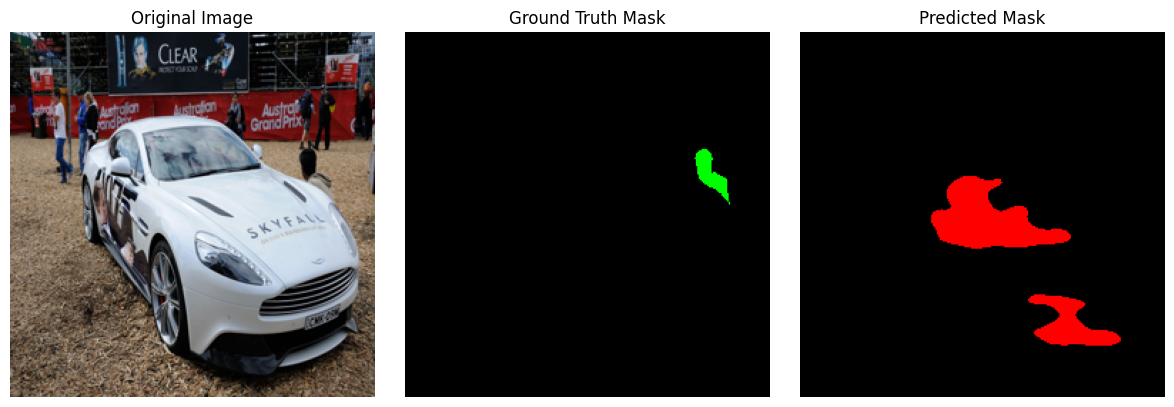

In [21]:
def mask_to_rgb(mask):
  rgb = np.zeros((*mask.shape, 3), dtype=np.uint8)
  for class_idx, color in LABEL_COLORS.items():
    rgb[mask == class_idx] = color
  return rgb

def visualize_predictions(model, dataset, device, num_images=5): # how many samples to visualise
  model.eval()
  for i in range(num_images):
    image, true_mask = dataset[i]
    image = image.to(device).unsqueeze(0)

    with torch.no_grad():
      output = model(image)
      pred_mask = torch.argmax(output.squeeze(), dim=0).cpu().numpy()

    image_np = image.squeeze().permute(1, 2, 0).cpu().numpy()
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())

    true_mask_np = true_mask.numpy()

    true_mask_rgb = mask_to_rgb(true_mask_np)
    pred_mask_rgb = mask_to_rgb(pred_mask)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(image_np)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask_rgb)
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask_rgb)
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

visualize_predictions(model, test_data, device, num_images=5)